## Install the dependencies

In [1]:
import sys
!{sys.executable} -m pip install tensorflow==2.11.0 opendatasets==0.1.22 pillow==9.0.1 matplotlib==3.5.3 numpy==1.21.5 tensorboard==2.11.2 scikit-learn==1.2.2 opencv-python==4.6.0.66

Defaulting to user installation because normal site-packages is not writeable


## Import libraries

In [2]:
import os
import opendatasets as od
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import preprocessing, optimizers, losses, layers, callbacks, applications
import cv2

2023-07-08 00:34:43.058293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 00:34:43.657664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-08 00:34:43.657701: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-08 00:34:45.666764: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Download the datasets
There a more possible datasets for our usecase. But this one from Kaggle is an easy start and contains quite a lot already.

In [3]:
od.download("https://www.kaggle.com/datasets/ubitquitin/geolocation-geoguessr-images-50k")

Skipping, found downloaded files in "./geolocation-geoguessr-images-50k" (use force=True to force download)


## Explore the dataset
Let's first plot one of the images, to see what we're dealing with.

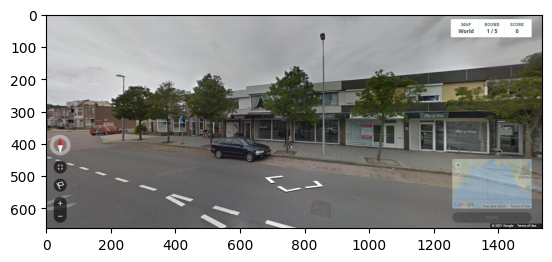

(662, 1536, 3)


In [4]:
img = Image.open("geolocation-geoguessr-images-50k/compressed_dataset/Netherlands/canvas_1629257895.jpg")
plt.imshow(img)
plt.show()
print(np.array(img).shape)

That looks good. Let's create our training and validation sets.  
But let's also preprocess the images because the model will only take square 244x244 images as input.  
The center contains more information that the edges,  
so let's crop the images to the center, and then resize them to 244x244.

Found 49997 files belonging to 124 classes.
Using 39998 files for training.


2023-07-08 00:34:53.890278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/horstl/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-07-08 00:34:53.890321: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-08 00:34:53.890350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (horstl-ThinkPad-T470): /proc/driver/nvidia/version does not exist
2023-07-08 00:34:53.896592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropr

Found 49997 files belonging to 124 classes.
Using 9999 files for validation.
(20, 662, 964, 3) (20, 124)


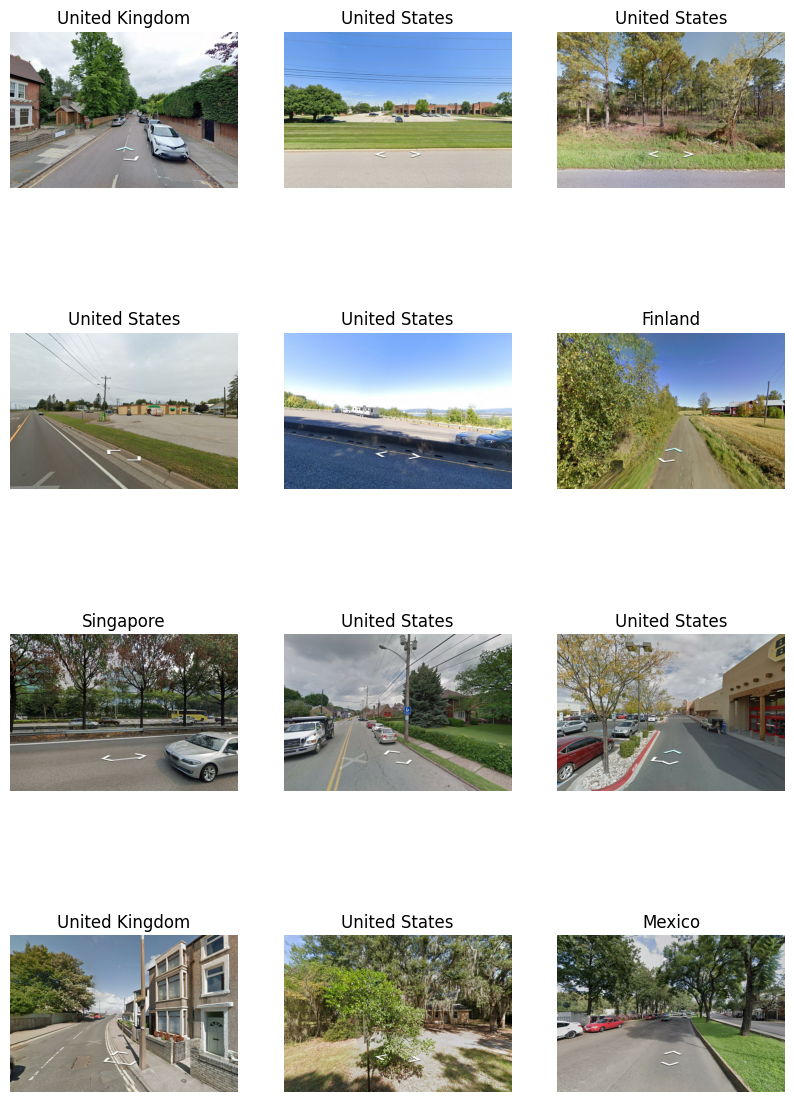

In [5]:
def custom_crop(image, label):
    # Crop the horizontal ends off and resize the image to 224x224
    return image[:, :, 286:1250, :], label

uncropped_train_ds = preprocessing.image_dataset_from_directory(
    "geolocation-geoguessr-images-50k/compressed_dataset",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=20,
    image_size=(662, 1536),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
)
train_ds = uncropped_train_ds.map(custom_crop)

val_ds = preprocessing.image_dataset_from_directory(
    "geolocation-geoguessr-images-50k/compressed_dataset",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=20,
    image_size=(662, 1536),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
).map(custom_crop)

train_images_batch, train_labels_batch = next(train_ds.as_numpy_iterator())
print(train_images_batch.shape, train_labels_batch.shape)
# Show the first 9 images from the batch with their labels
plt.figure(figsize=(10, 15))
for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(train_images_batch[i] / 255.0)
    plt.title(uncropped_train_ds.class_names[train_labels_batch[i].argmax()])
    plt.axis("off")

Let's look at the distribution of the labels

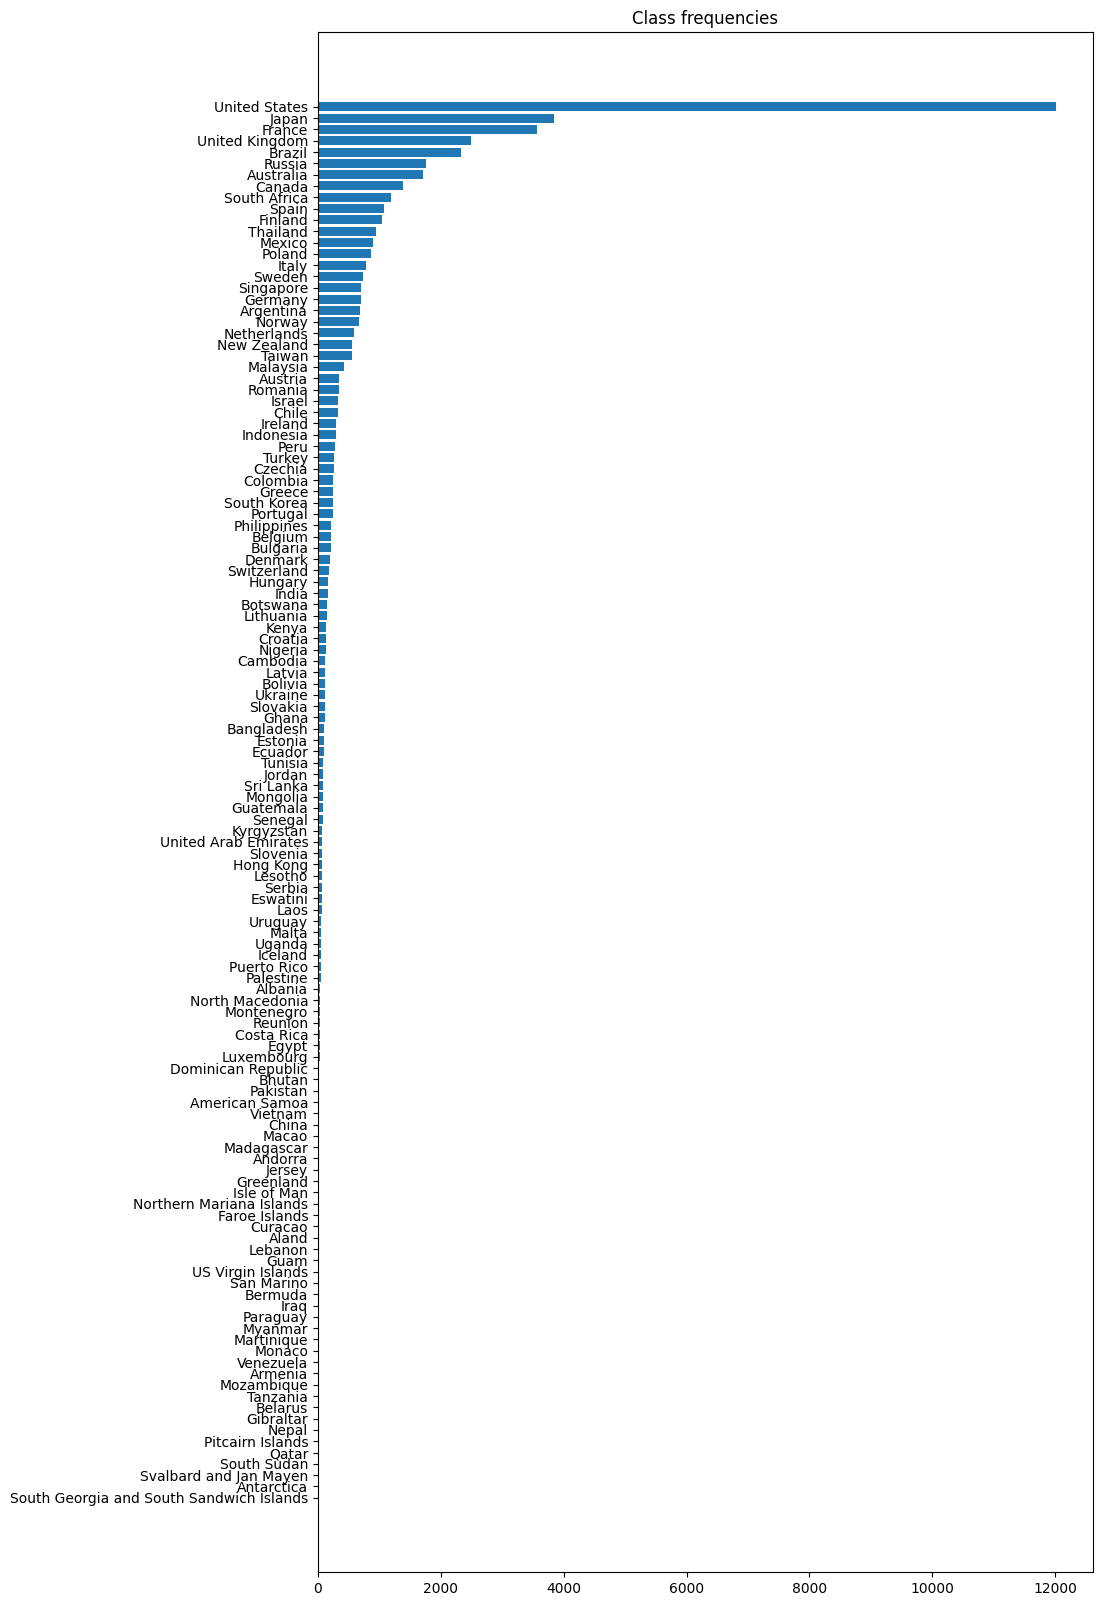

{'South Georgia and South Sandwich Islands': 1, 'Antarctica': 1, 'Svalbard and Jan Mayen': 1, 'South Sudan': 1, 'Qatar': 1, 'Pitcairn Islands': 1, 'Nepal': 1, 'Gibraltar': 1, 'Belarus': 1, 'Tanzania': 1, 'Mozambique': 1, 'Armenia': 1, 'Venezuela': 1, 'Monaco': 2, 'Martinique': 2, 'Myanmar': 2, 'Paraguay': 2, 'Iraq': 2, 'Bermuda': 3, 'San Marino': 4, 'US Virgin Islands': 6, 'Guam': 8, 'Lebanon': 8, 'Aland': 9, 'Curacao': 9, 'Faroe Islands': 9, 'Northern Mariana Islands': 10, 'Isle of Man': 11, 'Greenland': 11, 'Jersey': 12, 'Andorra': 13, 'Madagascar': 13, 'Macao': 13, 'China': 13, 'Vietnam': 15, 'American Samoa': 16, 'Pakistan': 19, 'Bhutan': 20, 'Dominican Republic': 22, 'Luxembourg': 25, 'Egypt': 27, 'Costa Rica': 27, 'Reunion': 29, 'Montenegro': 32, 'North Macedonia': 35, 'Albania': 41, 'Palestine': 46, 'Puerto Rico': 46, 'Iceland': 54, 'Uganda': 55, 'Malta': 55, 'Uruguay': 57, 'Laos': 61, 'Eswatini': 62, 'Serbia': 62, 'Lesotho': 65, 'Hong Kong': 66, 'Slovenia': 66, 'United Arab Emi

In [6]:
class_names = os.listdir("geolocation-geoguessr-images-50k/compressed_dataset")
frequencies = {class_name: len(os.listdir("geolocation-geoguessr-images-50k/compressed_dataset/" + class_name)) for class_name in class_names}
# Sort the dictionary by value in descending order
frequencies = {k: v for k, v in sorted(frequencies.items(), key=lambda item: item[1])}
# Use matplotlib to make a horizontal bar plot of the frequencies ordered from highest to lowest
fig, ax = plt.subplots(figsize=(10, 20))
ax.barh(list(frequencies.keys()), frequencies.values())
ax.set_title("Class frequencies")
plt.show()
print(frequencies)

As we can see, the dataset is very unbalanced.  
We will calculate the weights for each class, so that the model will be more sensitive to the minority classes.

In [7]:
class_weights = {i: 1 / frequencies[class_name] for i, class_name in enumerate(uncropped_train_ds.class_names)}

## Making the model

Let's first look what the original mobilenetv2 looks like

In [8]:
applications.MobileNetV2(
    input_shape=(662, 964, 3),
    include_top=False,
    weights="imagenet",
).summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 662, 964, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 331, 482, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 331, 482, 32  128         ['Conv1[0][0]']                  
                                )                                              

Now we make our own model that uses the MobileNetV2 model as a base and add a GlobalAveragePooling layer and a dense layer on top with finally a softmax activation. 

In [9]:
base_model = applications.MobileNetV2(
    input_shape=(662, 964, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False
inputs = tf.keras.Input(shape=(662, 964, 3))
base_model_outputs = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(base_model_outputs)
x = layers.Dense(124)(x)
outputs = layers.Softmax()(x)
model = tf.keras.Model(inputs, outputs)
multi_output_model = tf.keras.Model(
    inputs=inputs,
    outputs=(
        base_model_outputs,
        outputs
    )
)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 662, 964, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 21, 31, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 124)               158844    
                                                                 
 softmax (Softmax)           (None, 124)               0         
                                                                 
Total params: 2,416,828
Trainable params: 158,844
Non-trainab

Let's see the loss and accuracy before training

In [10]:
model.evaluate(val_ds, steps=3)

3/3 [==============================] - 34s 10s/step - loss: 4.9868 - accuracy: 0.0333


[4.98683500289917, 0.03333333507180214]

Use Tensorboard

In [11]:
tensorboard_callback = callbacks.TensorBoard(log_dir="logs")
%load_ext tensorboard
#%tensorboard --logdir logs/fit

Training the model

In [12]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    validation_steps=100,
    callbacks=[tensorboard_callback],
    class_weight=class_weights
)

Epoch 1/10
 496/2000 [======>.......................] - ETA: 4:56:33 - loss: 0.0118 - accuracy: 0.0065

## Export the model

In [20]:
if 'multi_output_model' in globals():
    multi_output_model.save("multi_output_model.h5")
    print("Saved model to disk")

Loaded model from disk


# Train the whole model further test

Make the base model trainable. And train further using the already trained weights

In [ ]:
base_model.trainable = True
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    validation_steps=100,
    callbacks=[tensorboard_callback],
    class_weight=class_weights
)

This doesn't seem to improve the accuracy.  
This might be able to work with some different hyperparameters, but I'm not going to try that now.  
Let's revert back to the checkpoint with the highest validation accuracy.  

In [10]:
multi_output_model = tf.keras.models.load_model("multi_output_model.h5")
print("Loaded model from disk")

Loaded model from disk


# Visualize Class Activation Maps

Visualize what the model looks at for a random image by taking the values before Global Average Pooling and then take the weighted average of the feature maps. This is called a class activation map.

1/1 [==============================] - 1s 1s/step


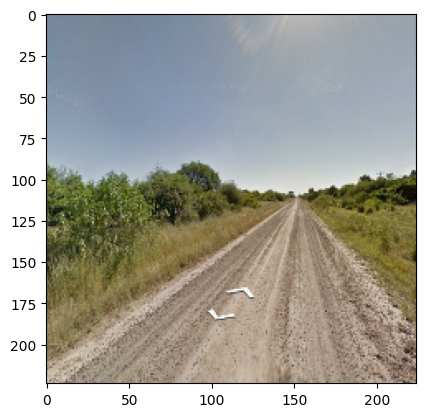

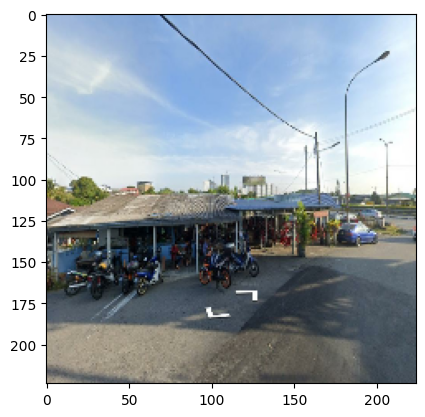

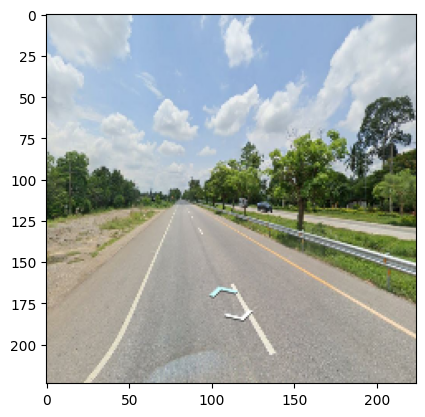

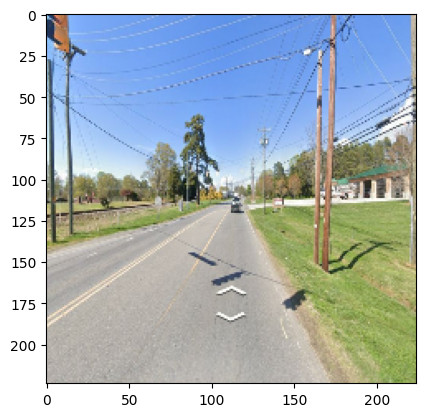

1/1 [==============================] - 1s 797ms/step


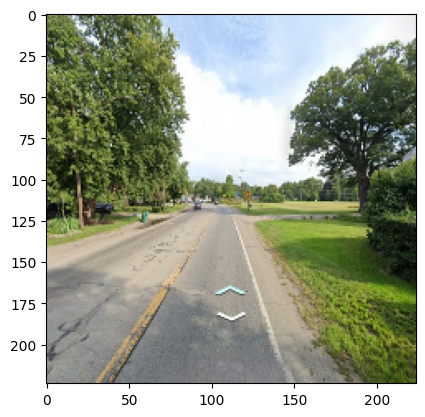

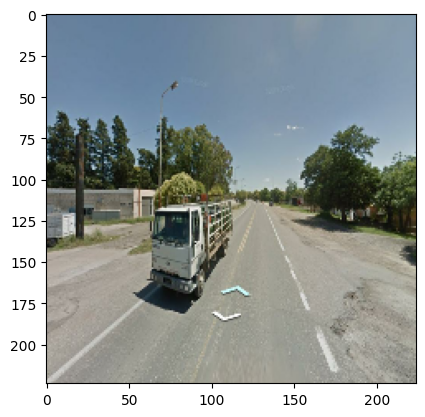

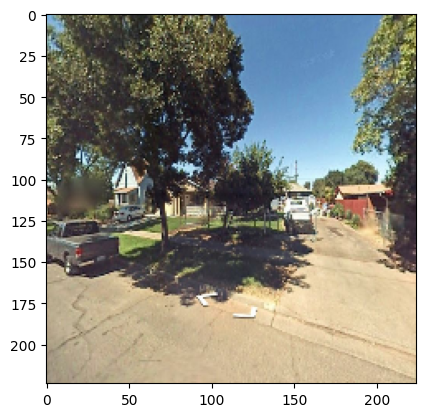

1/1 [==============================] - 1s 812ms/step


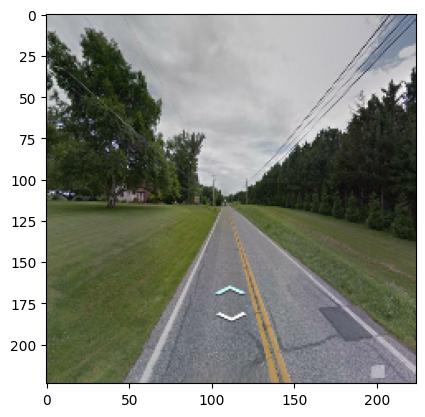

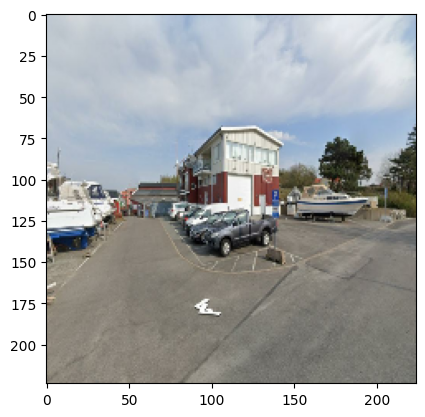

1/1 [==============================] - 1s 1s/step


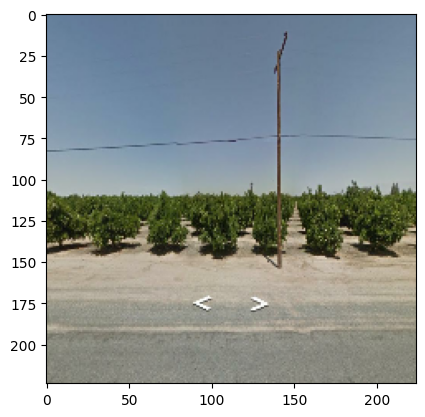

1/1 [==============================] - 1s 760ms/step


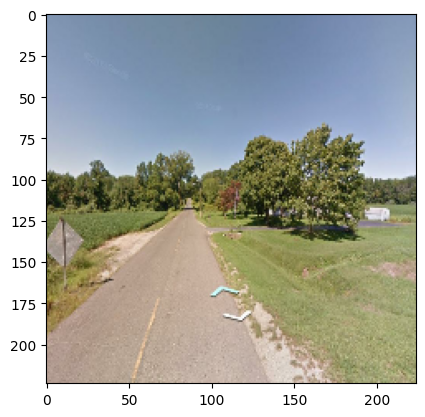

1/1 [==============================] - 1s 587ms/step


In [29]:
# Find the most "american" image in a subset of 100 images from the training set with batches of 20 images
american_image = None
american_image_prediction = 0
for images, labels in train_ds.take(100):
    base_model_outputs, predictions = multi_output_model.predict(images)
    for i, prediction in enumerate(predictions):
        if prediction[120] > american_image_prediction:
            american_image_prediction = prediction[120]
            american_image = images[i]
            plt.imshow(american_image / 255.0)
            plt.show()

In [24]:
uncropped_train_ds.class_names.index("United States")

120

1/1 [==============================] - 0s 74ms/step


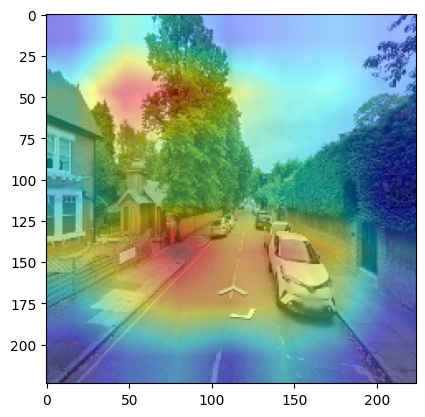

In [45]:
# select one image from the training set
one_image = train_images_batch[0]
# get the model predictions
base_model_outputs, predictions = multi_output_model.predict(np.expand_dims(one_image, axis=0))
# shape: (1, 7, 7, 1280) and (1, 124)
# Compute Class Activation Map (CAM) by multiplying the output of the last convolutional layer with the weights of the last dense layer
cam = np.matmul(base_model_outputs[0], multi_output_model.get_weights()[-2])
# Upsample the CAM to the size of the input image
cam = tf.image.resize(cam, (224, 224))
selected_cam = cam[:, :, 120]
# Normalize the CAM
selected_cam = selected_cam - np.min(selected_cam)
selected_cam = selected_cam / np.max(selected_cam)
# Convert the CAM to RGB and apply a colormap using OpenCV
heatmap = cv2.applyColorMap(np.uint8(255 * selected_cam), cv2.COLORMAP_JET)
# Apply the heatmap on the original image
superimposed_img = heatmap * 0.4 + one_image * 0.6
# Plot the superimposed image
plt.imshow(superimposed_img / 255.0)
plt.show()

## Evaluating the model

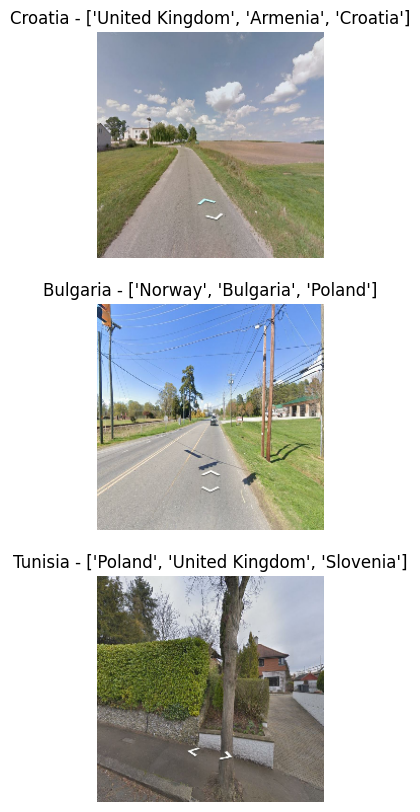

In [15]:
train_images_batch, train_labels_batch = next(train_ds.as_numpy_iterator())
predictions = model(train_images_batch[:3])

# Show the first 9 images from the batch with their labels
plt.figure(figsize=(4, 10))
for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    plt.imshow(train_images_batch[i] / 255.0)
    plt.title(f"{class_names[train_labels_batch[i].argmax()]} - {[x for x, _ in sorted(zip(class_names, predictions[i]), key=lambda x: x[1], reverse=True)][:3]}")
    plt.axis("off")

Make confusion matrix

In [16]:
# Collect 100 steps of predictions with the truth labels
predictions = []
truth = []
for i, (images, labels) in enumerate(val_ds):
    if i >= 50:
        break
    predictions.append(model.predict(images))
    truth.append(labels)

# Concatenate the predictions and truth labels since they are in batches
predictions = np.concatenate(predictions)
truth = np.concatenate(truth)

print(predictions.shape, truth.shape)

confusion_matrix(truth.argmax(axis=1), predictions.argmax(axis=1))



1/1 [==============================] - 0s 207ms/step
(1000, 124) (1000, 124)


array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  0,  0,  0],
       ...,
       [ 0,  6,  0, ..., 23,  1,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

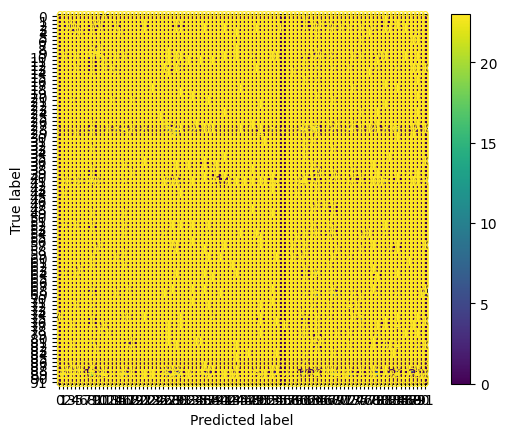

In [17]:
ConfusionMatrixDisplay(
    confusion_matrix(truth.argmax(axis=1), predictions.argmax(axis=1)),
    #display_labels=uncropped_train_ds.class_names
).plot()